<a href="https://colab.research.google.com/github/tasdid25/Django/blob/main/lms_backend_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# lms_backend -> settings-> Installed Apps ->

In [ ]:
INSTALLED_APPS = ['drf_yasg',
                  'rest_framework',
                  'rest_framework.authtoken',
                  'rest_framework_simplejwt',
                  'users',
                  'core',
                  ]

### #MODEL

#settings->

In [ ]:
AUTH_USER_MODEL = 'users.User'

#core-> models.py ->

In [ ]:
from django.db import models  # Import Django's model tools
from users.models import User  # Import custom User model

class Category(models.Model):
    title = models.CharField(max_length=255)  # Category name/title (max length 255 chars)

    def __str__(self):
        return self.title  # Return title when printing category object (for admin, shell, etc.)

class Enrollment(models.Model):
    # Link to User model; only users with role='student' can be chosen here
    student_id = models.ForeignKey(User, on_delete=models.CASCADE,  # Delete enrollments if user deleted
        limit_choices_to={'role': 'student'}  # Limit selectable users to students
    )
    # Link to Course model (assumed defined elsewhere)
    course_id = models.ForeignKey(
        Course, on_delete=models.CASCADE  # Delete enrollments if course deleted
    )

    def __str__(self):
        # Display "username - course title" when printed
        return f"{self.student_id.username} - {self.course_id.title}"

# etc...


### #SERIALIZER

#core-> serializers.py ->

In [ ]:
from rest_framework import serializers  # Import serializers from DRF
from .models import Course, Category, Lesson  # Import your models

# Serializer for Category model
class CategorySerializer(serializers.ModelSerializer):
    class Meta:
        model = Category  # Specify the model to serialize
        fields = '__all__'  # Include all fields from the model in the serialization
  #etc..

#core-> admin.py ->

In [ ]:
from django.contrib import admin
from .models import Course, Category, Lesson, Material, Enrollment, QuestionAnswer
# Register your models here.

admin.site.register(Category)
#etc..

# users-> serializers.py ->

In [ ]:
from rest_framework import serializers  # Import DRF's serializer tools
from .models import User  # Import your custom User model
from django.contrib.auth.hashers import make_password  # For securely hashing passwords

class UserSerializer(serializers.ModelSerializer):
    password = serializers.CharField(write_only=True, required=True)  # Don't show password in response

    class Meta:
        model = User  # Use the User model
        fields = ['id', 'username', 'email', 'role', 'mobile_no', 'password']  # Fields to include

    def create(self, validated_data):
        validated_data['password'] = make_password(validated_data['password'])  # Hash the password before saving
        return super().create(validated_data)  # Call parent create method to save user


#users-> admin.py ->

In [ ]:
from django.contrib import admin  # Import Django's admin interface

from . import models  # Import all models from the current app

admin.site.register(models.User)  # Register the User model so it shows up in the admin panel


### #LOGIN

# terminal ->

In [ ]:
py manage.py makemigration

In [ ]:
py manage.py migrate

In [ ]:
py manage.py createsuperuser
nz 123

In [ ]:
py manage.py runserver

 admin panel -> users ->  Role -> admin

### #VIEW




# @api view

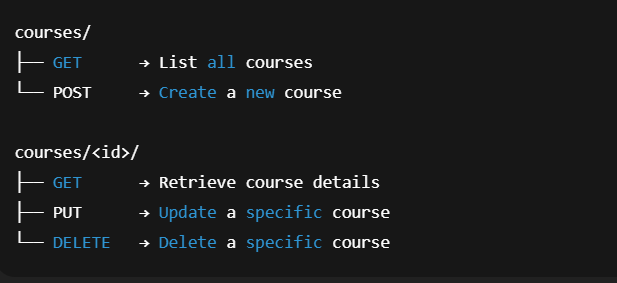

#core -> views.py -> category, course..

In [ ]:
from rest_framework.response import Response  # Return API responses
from rest_framework.decorators import api_view  # Mark function as API view
from rest_framework.permissions import IsAuthenticated  # For enforcing authentication (not used here)
from rest_framework import status  # HTTP status codes

from .models import Category, Course, Lesson, Material, Enrollment, QuestionAnswer  # Import models
from .serializers import (  # Import serializers to convert models to/from JSON
    CategorySerializer, CourseSerializer, LessonSerializer, MaterialSerializer,
    EnrollmentSerializer, QuestionAnswerSerializer
)

from drf_yasg.utils import swagger_auto_schema  # Decorator to add Swagger documentation for each API method

@swagger_auto_schema(method='put', request_body=CourseSerializer)

@api_view(['GET', 'POST'])  # Allow GET and POST methods only

@permission_classes([IsAuthenticated])  # Only authenticated users can access this view

def category_list_create(request):
    if request.method == 'GET':  # List all categories
        categories = Category.objects.all()  # Fetch all categories
        serializer = CategorySerializer(categories, many=True)  # Serialize list
        return Response(serializer.data)  # Return JSON response

    elif request.method == 'POST':  # Create new category
        if request.user.role != 'admin':  # Only admin allowed to create
            return Response({"detail": "Only admin can create categories."}, status=403)

        serializer = CategorySerializer(data=request.data)  # Deserialize input data
        if serializer.is_valid():  # Validate data
            serializer.save()  # Save new category
            return Response(serializer.data, status=status.HTTP_201_CREATED)  # Return created category
        return Response(serializer.errors, status=status.HTTP_400_BAD_REQUEST)  # Return validation errors


              # ---- copy-paste --- < but has different logic for user cases > -----------#


@api_view(['GET', 'POST'])  # Allow only GET and POST HTTP methods for this view

def course_list_create(request):
    if request.method == 'GET':  # Handle GET request to list courses
     #................................................................................
        if request.user.role == 'admin':
            courses = Course.objects.all() # Admin users see all courses


        elif request.user.role == 'teacher':
            courses = Course.objects.filter(teacher=request.user) # Teachers see only courses they teach


        elif request.user.role == 'student': # Students see all courses (could be filtered for enrolled courses)
            courses = Course.objects.all()  # You might want to filter enrolled courses here

        else:
            # If user role is unknown or unauthorized, return 403 Forbidden
            return Response({'detail': 'Unauthorized role'}, status=403)
     #................................................................................

        serializer = CourseSerializer(courses, many=True)
        return Response(serializer.data)

    elif request.method == 'POST':
#............................................................................................................
        if request.user.role != 'teacher':
          return Response({'detail': 'Only teachers can create courses.'}, status=403)

        serializer = CourseSerializer(data=request.data)
        if serializer.is_valid():
            serializer.save(teacher=request.user)  # assuming you have a teacher FK in model
#.............................................................................................................
        return Response(serializer.data, status=status.HTTP_201_CREATED)  # Return created category
    return Response(serializer.errors, status=status.HTTP_400_BAD_REQUEST)  # Return validation errors

In [ ]:
@swagger_auto_schema(method='put', request_body=CourseSerializer)
@api_view(['GET', 'PUT', 'DELETE'])
@permission_classes([IsAuthenticated])
def course_detail(request, pk):
    try:
        course = Course.objects.get(pk=pk) #ekta single course ke visit korbo check korte ase naki
    except Course.DoesNotExist:
        return Response({'detail': 'Course not found'}, status=404)

    if request.method == 'GET':
        if request.user.role == 'admin' or request.user == course.instructor_id: # je instructor course create korse only shey e jeno dkhte pare
            serializer = CourseSerializer(course)
            return Response(serializer.data)
        return Response({'detail': 'Permission denied'}, status=403)

    elif request.method == 'PUT':
        if request.user.role != 'teacher' or request.user != course.instructor_id:
            return Response({'detail': 'Only the course owner (teacher) can update this course.'}, status=403)

        serializer = CourseSerializer(course, data=request.data)
        if serializer.is_valid():
            serializer.save(teacher=request.user)
            return Response(serializer.data)
        return Response(serializer.errors, status=status.HTTP_400_BAD_REQUEST)

    elif request.method == 'DELETE':
        if request.user.role != 'teacher' or request.user != course.instructor_id:
            return Response({'detail': 'Only the course owner (teacher) can delete this course.'}, status=403)
        course.delete()
        return Response({'detail': 'Course deleted'}, status=status.HTTP_204_NO_CONTENT)

### #URL

#core -> urls.py


In [ ]:
from django.urls import path
from .views import category_list_create, course_list_create, course_detail, lesson_list_create, material_list_create, enrollment_list_create, questionanswer_list_create

urlpatterns = [
    path('categories/', category_list_create, name='category_list_create'),
    path('courses/<int:pk>/', course_detail, name='course_detail'),]

#settings->

In [ ]:
ROOT_URLCONF = 'lms_backend.urls'


#lms backend -> urls.py


In [ ]:
from django.contrib import admin
from django.urls import path, include

urlpatterns = [
    path('admin/', admin.site.urls),
    path('api/', include('core.urls')),]

#check API status:

*   browser-> "detail": "Authentication credentials were not provided."
*   also copy the url in postman


In [ ]:
py manage.py runserver
http://127.0.0.1:8000/api/courses/

### #JWT TOKEN SETUP

# users -> views.py

In [ ]:
from django.shortcuts import render
from django.shortcuts import render
from rest_framework.response import Response
from rest_framework import status
from rest_framework.decorators import api_view, permission_classes
from rest_framework.permissions import IsAuthenticated
from .models import User
from .serializers import UserSerializer


@api_view(['GET', 'POST'])
def user_list_create(request):
    if request.method == 'GET':
        if not request.user.is_authenticated :
            return Response({'detail' : 'Authentication credentials were not provided'}, status=401)

        if request.user.role == 'admin':
            users = User.objects.all()
        else:
            users = User.objects.filter(id=request.user.id) #je user request kortese shey just nijertai dkhte parbe

        serializer = UserSerializer(users, many=True)
        return Response(serializer.data)

    elif request.method == 'POST':
        serializer = UserSerializer(data=request.data)
        if serializer.is_valid():
            serializer.save()
            return Response(serializer.data, status=status.HTTP_201_CREATED)
        return Response(serializer.errors, status=status.HTTP_400_BAD_REQUEST)



# users -> urls.py

In [ ]:
from django.urls import path
from .views import user_list_create

urlpatterns = [
    path('auth/', user_list_create, name="user_list_create"),
]


#lms_backend -> urls.py


In [ ]:
urlpatterns = [
    path('admin/', admin.site.urls),
    path('api/', include('core.urls')),
    path('api/user/', include('users.urls')),]

#JWT_requirement



In [ ]:
pip install djangorestframework-simplejwt

# lms_backend -> settings

In [ ]:
REST_FRAMEWORK = {
    'DEFAULT_AUTHENTICATION_CLASSES': (
        'rest_framework_simplejwt.authentication.JWTAuthentication',
    )
}

# lms_backend -> urls.py

In [ ]:
from django.contrib import admin
from django.urls import path, include
from rest_framework_simplejwt.views import (
    TokenObtainPairView,
    TokenRefreshView,
    TokenVerifyView,
)


urlpatterns = [
    path('admin/', admin.site.urls),
    path('api/', include('core.urls')),
    path('api/user/', include('users.urls')),
    path('api/token/', TokenObtainPairView.as_view(), name='token_obtain_pair'),
    path('api/token/refresh/', TokenRefreshView.as_view(), name='token_refresh'),
    path('api/token/verify/', TokenVerifyView.as_view(), name='token_verify'), ]

# lms_backend -> settings


*   ACCESS_TOKEN_LIFETIME




In [ ]:
from datetime import timedelta

SIMPLE_JWT = {
    "ACCESS_TOKEN_LIFETIME": timedelta(minutes=15),
    "REFRESH_TOKEN_LIFETIME": timedelta(days=7),
    "ROTATE_REFRESH_TOKENS": True,
    "BLACKLIST_AFTER_ROTATION": True,
}

#core -> views.py-> after every @api_view

In [ ]:
@permission_classes([IsAuthenticated])

# terminal ->

In [ ]:
py manage.py makemigration
py manage.py migrate
py manage.py runserver

#check API status:

*   browser-> "detail": "Authentication credentials were not provided."
*   also copy the url in postman


In [ ]:
py manage.py runserver
http://127.0.0.1:8000/api/courses/

In [ ]:
http://127.0.0.1:8000/api/user/auth/

#media type -> applicayion/json

#vscode-> users-> serializers.py -> fields copy -> paste in contant-> {'id':'2', 'username':'rahim', etc}